In [1]:
%matplotlib inline

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt
from scipy.stats import uniform, randint

In [3]:
# path to project directory
path = Path('./')

In [4]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train_v2.csv', index_col=0, dtype={'season':str})

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78974 entries, 0 to 78973
Data columns (total 35 columns):
player                                 78974 non-null object
gw                                     78974 non-null int64
position                               78974 non-null int64
minutes                                78974 non-null int64
team                                   78974 non-null object
opponent_team                          78974 non-null object
relative_market_value_team             78974 non-null float64
relative_market_value_opponent_team    78974 non-null float64
was_home                               78974 non-null bool
total_points                           78974 non-null int64
assists                                78974 non-null int64
bonus                                  78974 non-null int64
bps                                    78974 non-null int64
clean_sheets                           78974 non-null int64
creativity                             78974 

In [6]:
# player level lag features
def player_lag_features(df, features, lags):    
    df_new = df.copy()
    
    # need minutes for per game stats, add to front of list
    features.insert(0, 'minutes')

    # calculate totals for each lag period
    for feature in features:
        for lag in lags:
            feature_name = feature + '_last_' + str(lag)
            
            if lag == 'all':
                df_new[feature_name] = df_new.groupby(['player'])[feature].apply(lambda x: x.cumsum() - x)
            else: 
                df_new[feature_name] = df_new.groupby(['player'])[feature].apply(lambda x: x.rolling(min_periods=1, 
                                                                                            window=lag+1).sum() - x)
            if feature != 'minutes':
                minute_name = 'minutes_last_' + str(lag)
                pg_feature_name = feature + '_pg_last_' + str(lag)
                
                df_new[pg_feature_name] = 90 * df_new[feature_name] / df_new[minute_name] 
                df_new[pg_feature_name] = df_new[pg_feature_name].fillna(0)
                
    return df_new


In [68]:
# team level lag features
def team_lag_features(df, features, lags):
    for feature in features:
        feature_team_name = feature + '_team'
        feature_team = (df.groupby(['team', 'season', 'gw',
                                   'kickoff_time', 'opponent_team'])
                        [feature].sum().rename(feature_team_name).reset_index())
                
        for lag in lags:
            feature_name = feature + '_team_last_' + str(lag)
            pg_feature_name = feature + '_team_pg_last_' + str(lag)
            
            if lag == 'all':
                feature_team[feature_name] = (feature_team.groupby('team')[feature_team_name]
                                              .apply(lambda x: x.cumsum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name]
                                                 / feature_team.groupby('team').cumcount())
                
            else:
                feature_team[feature_name] = (feature_team.groupby('team')[feature_team_name]
                                              .apply(lambda x: x.rolling(min_periods=1, 
                                                                         window=lag + 1).sum() - x))
                
                feature_team[pg_feature_name] = (feature_team[feature_name] / 
                                                 feature_team.groupby('team')[feature_team_name]
                                                 .apply(lambda x: x.rolling(min_periods=1, 
                                                                            window=lag + 1).count() - 1))
        
        df_new = df.merge(feature_team, 
                          on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'], 
                          how='left')
        
        df_new = df_new.merge(feature_team,
                 left_on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'],
                 right_on=['team', 'season', 'gw', 'kickoff_time', 'opponent_team'],
                 how='left',
                 suffixes = ('', '_opponent'))
        
        return df_new


In [69]:
train_df_1 = team_lag_features(train_df, ['goals_scored'], ['all', 1, 2])
#train_df_ = player_lag_features(train_df, ['total_points'], ['all', 1, 2])

In [70]:
train_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78974 entries, 0 to 78973
Data columns (total 49 columns):
player                                    78974 non-null object
gw                                        78974 non-null int64
position                                  78974 non-null int64
minutes                                   78974 non-null int64
team                                      78974 non-null object
opponent_team                             78974 non-null object
relative_market_value_team                78974 non-null float64
relative_market_value_opponent_team       78974 non-null float64
was_home                                  78974 non-null bool
total_points                              78974 non-null int64
assists                                   78974 non-null int64
bonus                                     78974 non-null int64
bps                                       78974 non-null int64
clean_sheets                              78974 non-null int64
cre

In [286]:
train_df.to_csv(path/'checks.csv')

In [89]:
def create_xgb(df, validation, params, dep_var, cat_vars, cont_vars, 
               player_lag_vars, team_lag_vars, player_lags, team_lags):
    
    df_new = df.copy()
    
    # add lag vars
    df_new = player_lag_features(df_new, player_lag_vars.copy(), player_lags)
    df_new = team_lag_features(df_new, team_lag_vars, team_lags)
    
    # add lag var names
    for player_lag_var in player_lag_vars:
        for player_lag in player_lags:
            feature_name = player_lag_var + '_pg_last_' + str(player_lag)
            cont_vars.append(feature_name)
            
    for team_lag_var in team_lag_vars:
        for team_lag in team_lags:
            feature_name = team_lag_var + '_team_pg_last_' + str(team_lag)
            feature_name_opposition = feature_name + '_opponent'
            cont_vars.extend([feature_name, feature_name_opposition])
    
    print(cont_vars)
    
    X, y = df_new[cat_vars + cont_vars].copy(), df_new[dep_var].copy()
    
    # find validation cut point - index for 18-19 season second half (gw 19)
    valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 20)].index.min()
    valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()
    
    X['position'] = X['position'].apply(str)
    enc = LabelEncoder()
    X['season'] = enc.fit_transform(X['season'])
    X_dict = X.to_dict("records")

    # Create the DictVectorizer object: dv
    dv = DictVectorizer(sparse=False, separator='_')

    # Apply dv on df: df_encoded
    X_encoded = dv.fit_transform(X_dict)
    
    X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
    
    # training and validation sets
    if validation == 'no-search':
        X_train = X_df[:valid_start]
        y_train = y[:valid_start]
        X_test = X_df[valid_start:valid_end]
        y_test = y[valid_start:valid_end]
        
        xg_reg = xgb.XGBRegressor(gamma=0.047479, learning_rate=0.0828905304021426, max_depth=5, n_estimators=75, subsample=0.6862963240045978)
        
        xg_reg.fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(preds, y_test))
        print("RMSE: %f" % (rmse))
    
    else:
        X_train = X_df[0:valid_end]
        y_train = y[0:valid_end]
        test_fold = np.repeat([-1, 0], [valid_start, valid_end - valid_start])
        ps = PredefinedSplit(test_fold)
        
        # Instantiate the regressor: gbm
        gbm = xgb.XGBRegressor(objective="reg:squarederror")
        
        # Perform random search: grid_mse
        randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=25, 
                                    cv=ps, 
                                    verbose=1)
        
        # Fit randomized_mse to the data
        randomized_mse.fit(X_train, y_train)
        
        # Print the best parameters and lowest RMSE
        print("Best parameters found: ", randomized_mse.best_params_)
        print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))
    

In [91]:
validation = 'random'

# params = {"gamma": 0.05, 
#         "learning_rate": 0.1, 
#         "max_depth": 5,
#         "n_estimators": 100, 
#         "subsample":0.7}

params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

dep_var = 'total_points'
cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['gw', 'minutes']
#, 'relative_market_value_team', 'relative_market_value_opponent_team']
player_lag_vars = ['total_points']
team_lag_vars = ['total_points']
player_lags = ['all', 1 ,2 ,3, 5, 10]
team_lags = ['all', 1, 2, 3, 5, 10]

create_xgb(train_df, validation, params, dep_var, cat_vars, cont_vars, 
               player_lag_vars, team_lag_vars, player_lags, team_lags)

['gw', 'minutes', 'total_points_pg_last_all', 'total_points_pg_last_1', 'total_points_pg_last_2', 'total_points_pg_last_3', 'total_points_pg_last_5', 'total_points_pg_last_10', 'total_points_team_pg_last_all', 'total_points_team_pg_last_all_opponent', 'total_points_team_pg_last_1', 'total_points_team_pg_last_1_opponent', 'total_points_team_pg_last_2', 'total_points_team_pg_last_2_opponent', 'total_points_team_pg_last_3', 'total_points_team_pg_last_3_opponent', 'total_points_team_pg_last_5', 'total_points_team_pg_last_5_opponent', 'total_points_team_pg_last_10', 'total_points_team_pg_last_10_opponent']
Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprec

Best parameters found:  {'gamma': 0.49799877563991035, 'learning_rate': 0.16920707401349566, 'max_depth': 2, 'n_estimators': 181, 'subsample': 0.6645142640533779}
Lowest RMSE found:  1.8486218325691257


In [148]:
train_df.head()

player  gw  position  minutes             team  \
0     Aaron_Cresswell   1         2        0  West Ham United   
1        Aaron_Lennon   1         3       15          Everton   
2        Aaron_Ramsey   1         3       60          Arsenal   
3  Abdoulaye_Doucouré   1         3        0          Watford   
4   Abdul Rahman_Baba   1         2        0          Chelsea   

       opponent_team  relative_market_value_team  \
0            Chelsea                    0.895471   
1  Tottenham Hotspur                    1.057509   
2          Liverpool                    1.944129   
3        Southampton                    0.704200   
4    West Ham United                    2.243698   

   relative_market_value_opponent_team  was_home  total_points  ...  \
0                             2.243698     False             0  ...   
1                             1.433690      True             1  ...   
2                             1.465860      True             2  ...   
3                             0.796805     False             0  ...   
4                             0.895471      True             0  ...   

   total_points_last_3  total_points_pg_last_3  total_points_last_4  \
0                  0.0                     0.0                  0.0   
1                  0.0                     0.0                  0.0   
2                  0.0                     0.0                  0.0   
3                  0.0                     0.0                  0.0   
4                  0.0                     0.0                  0.0   

   total_points_pg_last_4  total_points_last_5  total_points_pg_last_5  \
0                     0.0                  0.0                     0.0   
1                     0.0                  0.0                     0.0   
2                     0.0                  0.0                     0.0   
3                     0.0                  0.0                     0.0   
4                     0.0                  0.0                     0.0   

   total_points_last_10  total_points_pg_last_10  total_points_last_20  \
0                   0.0                      0.0                   0.0   
1                   0.0                      0.0                   0.0   
2                   0.0                      0.0                   0.0   
3                   0.0                      0.0                   0.0   
4                   0.0                      0.0                   0.0   

   total_points_pg_last_20  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 71 columns]

In [176]:
train_df[train_df['player'] == 'Harry_Kane'].head(10)

player  gw  position  minutes               team  \
202   Harry_Kane   1         4       90  Tottenham Hotspur   
729   Harry_Kane   2         4       89  Tottenham Hotspur   
1270  Harry_Kane   3         4       82  Tottenham Hotspur   
1830  Harry_Kane   4         4       72  Tottenham Hotspur   
2412  Harry_Kane   5         4       86  Tottenham Hotspur   
2997  Harry_Kane   6         4        0  Tottenham Hotspur   
3584  Harry_Kane   7         4        0  Tottenham Hotspur   
4174  Harry_Kane   8         4        0  Tottenham Hotspur   
4767  Harry_Kane   9         4        0  Tottenham Hotspur   
5363  Harry_Kane  10         4        0  Tottenham Hotspur   

             opponent_team  relative_market_value_team  \
202                Everton                     1.43369   
729         Crystal Palace                     1.43369   
1270             Liverpool                     1.43369   
1830            Stoke City                     1.43369   
2412            Sunderland                     1.43369   
2997         Middlesbrough                     1.43369   
3584       Manchester City                     1.43369   
4174  West Bromwich Albion                     1.43369   
4767           Bournemouth                     1.43369   
5363        Leicester City                     1.43369   

      relative_market_value_opponent_team  was_home  total_points  ...  \
202                              1.057509     False             2  ...   
729                              0.802197      True             5  ...   
1270                             1.465860      True             2  ...   
1830                             0.718705     False             6  ...   
2412                             0.418392      True             9  ...   
2997                             0.452793     False             0  ...   
3584                             2.311012      True             0  ...   
4174                             0.428062     False             0  ...   
4767                             0.384921     False             0  ...   
5363                             0.650832      True             0  ...   

      total_points_last_3  total_points_pg_last_3  total_points_last_4  \
202                   0.0                0.000000                  0.0   
729                   2.0                2.000000                  2.0   
1270                  7.0                3.519553                  7.0   
1830                  9.0                3.103448                  9.0   
2412                 13.0                4.814815                 15.0   
2997                 17.0                6.375000                 22.0   
3584                 15.0                8.544304                 17.0   
4174                  9.0                9.418605                 15.0   
4767                  0.0                0.000000                  9.0   
5363                  0.0                0.000000                  0.0   

      total_points_pg_last_4  total_points_last_5  total_points_pg_last_5  \
202                 0.000000                  0.0                0.000000   
729                 2.000000                  2.0                2.000000   
1270                3.519553                  7.0                3.519553   
1830                3.103448                  9.0                3.103448   
2412                4.054054                 15.0                4.054054   
2997                6.018237                 24.0                5.155131   
3584                6.375000                 22.0                6.018237   
4174                8.544304                 17.0                6.375000   
4767                9.418605                 15.0                8.544304   
5363                0.000000                  9.0                9.418605   

      total_points_last_10  total_points_pg_last_10  total_points_last_20  \
202                    0.0                 0.000000                   0.0   
729                    2.0                 2.000000     

In [150]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78974 entries, 0 to 78973
Data columns (total 71 columns):
player                                 78974 non-null object
gw                                     78974 non-null int64
position                               78974 non-null int64
minutes                                78974 non-null int64
team                                   78974 non-null object
opponent_team                          78974 non-null object
relative_market_value_team             78974 non-null float64
relative_market_value_opponent_team    78974 non-null float64
was_home                               78974 non-null bool
total_points                           78974 non-null int64
assists                                78974 non-null int64
bonus                                  78974 non-null int64
bps                                    78974 non-null int64
clean_sheets                           78974 non-null int64
creativity                             78974 

In [151]:
# set categorical, continuous variables
# and dependent variable
cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['gw', 'minutes', 'relative_market_value_team', 
             'relative_market_value_opponent_team', 
#              'minutes_last_all', 
#              'minutes_last_1', 
#              'minutes_last_2',
#              'minutes_last_3',
#              'minutes_last_4',
#              'minutes_last_5',
#              'minutes_last_10',
#              'minutes_last_20',
#              'total_points_last_all',
#              'total_points_last_1',
#              'total_points_last_2',
#              'total_points_last_3',
#              'total_points_last_4',
#              'total_points_last_5',
#              'total_points_last_10',
#              'total_points_last_20',
             'total_points_pg_last_all',
             'total_points_pg_last_1',
             'total_points_pg_last_2',
             'total_points_pg_last_3',
             'total_points_pg_last_4',
             'total_points_pg_last_5',
             'total_points_pg_last_10',
             'total_points_team_pg_all',
             'total_points_team_pg_last_1',
             'total_points_team_pg_last_2',
             'total_points_team_pg_last_3',
             'total_points_team_pg_last_4',
             'total_points_team_pg_last_5',
             'total_points_team_pg_last_10',
             'total_points_team_pg_last_20']
dep_var = 'total_points'

In [152]:
X, y = train_df[cat_vars + cont_vars].copy(), train_df[dep_var].copy()

In [ ]:
# find validation cut point - index for 18-19 season second half (gw 19)
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 20)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()

In [154]:
X['position'] = X['position'].apply(str)

In [155]:
#X['season'] = X['season'].replace({'1617':1, '1718':2, '1819':3, '1920':4})
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])

In [156]:
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

In [157]:
X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
X_df.head()

gw  minutes  opponent_team_Arsenal  opponent_team_Aston Villa  \
0  1.0      0.0                    0.0                        0.0   
1  1.0     15.0                    0.0                        0.0   
2  1.0     60.0                    0.0                        0.0   
3  1.0      0.0                    0.0                        0.0   
4  1.0      0.0                    0.0                        0.0   

   opponent_team_Bournemouth  opponent_team_Brighton and Hove Albion  \
0                        0.0                                     0.0   
1                        0.0                                     0.0   
2                        0.0                                     0.0   
3                        0.0                                     0.0   
4                        0.0                                     0.0   

   opponent_team_Burnley  opponent_team_Cardiff City  opponent_team_Chelsea  \
0                    0.0                         0.0                    1.0   
1                    0.0                         0.0                    0.0   
2                    0.0                         0.0                    0.0   
3                    0.0                         0.0                    0.0   
4                    0.0                         0.0                    0.0   

   opponent_team_Crystal Palace  ...  total_points_pg_last_all  \
0                           0.0  ...                       0.0   
1                           0.0  ...                       0.0   
2                           0.0  ...                       0.0   
3                           0.0  ...                       0.0   
4                           0.0  ...                       0.0   

   total_points_team_pg_all  total_points_team_pg_last_1  \
0                       NaN                          0.0   
1                       NaN                          0.0   
2                       NaN                          0.0   
3                       NaN                          0.0   
4                       NaN                          0.0   

   total_points_team_pg_last_10  total_points_team_pg_last_2  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   

   total_points_team_pg_last_20  total_points_team_pg_last_3  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   

   total_points_team_pg_last_4  total_points_team_pg_last_5  was_home  
0                          0.0                          0.0       0.0  
1                          0.0                          0.0       1.0  
2                          0.0                          0.0       1.0  
3                          0.0                          0.0       0.0  
4                          0.0                          0.0       1.0  

[5 rows x 83 columns]

In [158]:
X_df.columns

Index(['gw', 'minutes', 'opponent_team_Arsenal', 'opponent_team_Aston Villa',
       'opponent_team_Bournemouth', 'opponent_team_Brighton and Hove Albion',
       'opponent_team_Burnley', 'opponent_team_Cardiff City',
       'opponent_team_Chelsea', 'opponent_team_Crystal Palace',
       'opponent_team_Everton', 'opponent_team_Fulham',
       'opponent_team_Huddersfield Town', 'opponent_team_Hull City',
       'opponent_team_Leicester City', 'opponent_team_Liverpool',
       'opponent_team_Manchester City', 'opponent_team_Manchester United',
       'opponent_team_Middlesbrough', 'opponent_team_Newcastle United',
       'opponent_team_Norwich', 'opponent_team_Sheffield United',
       'opponent_team_Southampton', 'opponent_team_Stoke City',
       'opponent_team_Sunderland', 'opponent_team_Swansea City',
       'opponent_team_Tottenham Hotspur', 'opponent_team_Watford',
       'opponent_team_West Bromwich Albion', 'opponent_team_West Ham United',
       'opponent_team_Wolverhampton Wand

In [161]:
X_train = X_df[0:valid_end]
y_train = y[0:valid_end]

In [162]:
test_fold = np.repeat([-1, 0], [valid_start, valid_end - valid_start])

In [163]:
len(test_fold)

67936

In [164]:
ps = PredefinedSplit(test_fold)

In [152]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    #'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'learning_rate': [0.1]
}

In [165]:
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

In [166]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

In [167]:
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=25, 
                                    cv=ps, 
                                    verbose=1)

In [168]:
xgb.__version__

'0.90'

In [169]:
# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprec

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001CF30F88>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001

In [170]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'gamma': 0.286192537317673, 'learning_rate': 0.17826132701478217, 'max_depth': 3, 'n_estimators': 55, 'subsample': 0.834465012293063}
Lowest RMSE found:  1.8528600305549938


In [171]:
# training and validation sets
X_train = X_df[:valid_start]
y_train = y[:valid_start]
X_test = X_df[valid_start:valid_end]
y_test = y[valid_start:valid_end]

In [172]:
#xg_reg = xgb.XGBRegressor(n_estimators=75, max_depth=5, learning_rate=0.1)

xg_reg = xgb.XGBRegressor(gamma=0.047479, learning_rate=0.0828905304021426, max_depth=5, n_estimators=75, subsample=0.6862963240045978)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(preds, y_test))
print("RMSE: %f" % (rmse))

C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[21:58:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.855123


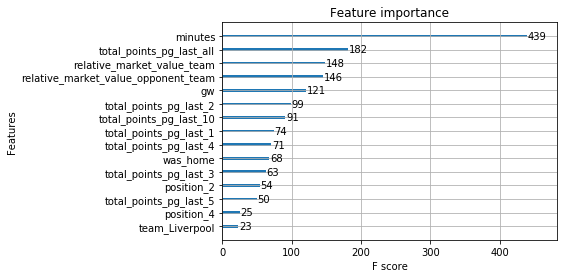

In [40]:
#plt.style.use('ggplot')
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

In [59]:
max(preds)

8.015433

In [22]:
results = X_test.merge(y_test.to_frame(), left_index=True, right_index=True)
results['preds'] = preds
results

gw  minutes  opponent_team_Arsenal  opponent_team_Aston Villa  \
56539  20.0     90.0                    0.0                        0.0   
56540  20.0      0.0                    0.0                        0.0   
56541  20.0      0.0                    0.0                        0.0   
56542  20.0     90.0                    0.0                        0.0   
56543  20.0     90.0                    0.0                        0.0   
56544  20.0      0.0                    0.0                        0.0   
56545  20.0      0.0                    0.0                        0.0   
56546  20.0     36.0                    0.0                        0.0   
56547  20.0     45.0                    0.0                        0.0   
56548  20.0      0.0                    0.0                        0.0   
56549  20.0      0.0                    0.0                        0.0   
56550  20.0     58.0                    0.0                        0.0   
56551  20.0     12.0                    1.0                        0.0   
56552  20.0     77.0                    0.0                        0.0   
56553  20.0      0.0                    0.0                        0.0   
56554  20.0      0.0                    0.0                        0.0   
56555  20.0     90.0                    0.0                        0.0   
56556  20.0      0.0                    0.0                        0.0   
56557  20.0      0.0                    0.0                        0.0   
56558  20.0     90.0                    0.0                        0.0   
56559  20.0      0.0                    1.0                        0.0   
56560  20.0     90.0                    0.0                        0.0   
56561  20.0      0.0                    0.0                        0.0   
56562  20.0     17.0                    0.0                        0.0   
56563  20.0     19.0                    0.0                        0.0   
56564  20.0      0.0                    0.0                        0.0   
56565  20.0     90.0                    0.0                        0.0   
56566  20.0     90.0                    0.0                        0.0   
56567  20.0      0.0                    1.0                        0.0   
56568  20.0     64.0                    0.0                        0.0   
...     ...      ...                    ...                        ...   
67906  38.0     45.0                    0.0                        0.0   
67907  38.0      0.0                    0.0                        0.0   
67908  38.0     13.0                    0.0                        0.0   
67909  38.0     85.0                    0.0                        0.0   
67910  38.0     90.0                    0.0                        0.0   
67911  38.0      0.0                    0.0                        0.0   
67912  38.0      0.0                    0.0                        0.0   
67913  38.0      0.0                    0.0                        0.0   
67914  38.0      0.0                    0.0                        0.0   
67915  38.0     65.0                    0.0                        0.0   
67916  38.0     86.0                    0.0                        0.0   
67917  38.0     68.0                    0.0                        0.0   
67918  38.0     90.0                    0.0                        0.0   
67919  38.0     90.0                    0.0                        0.0   
67920  38.0     66.0                    0.0                        0.0   
67921  38.0      0.0                    0.0                        0.0   
67922  38.0      0.0                    0.0                        0.0   
67923  38.0      0.0                    0.0                        0.0   
67924  38.0      0.0                    0.0                        0.0   
67925  38.0     90.0                    0.0                        0.0   
67926  38.0     90.0                    0.0                        0.0   
67927  38.0      0.0                    0.0                        0.0   
67928  38.0  